# Energy consumption prediction
* Brocco Mattia **|** 873058
* Piccolo Giulio **|** 874727

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

import linear_model_tests as lmt
import decision_tree_opt as dto
import Data_viz as dv

%reload_ext autoreload
%autoreload 2

viz = dv.Graphs()
lin_mod = lmt.Test()
opt_tree = dto.Parameters()

C:\Users\matti\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## DATA EXPLORATION AND CLEANSING

In [2]:
data = pd.read_csv("energydata_complete.csv", parse_dates=["date"])
data = data.dropna()
names = ["date","appliance_wh", "light_wh","kitchen_celsius","kitchen_hum_perc",
        "living_celsius","living_hum_perc","laundry_celsius","laundry_hum_perc","office_celsius","office_hum_perc",
         "bathroom_celsius","bathroom_hum_perc","portico_celsius","portico_hum_perc","ironing_celsius","ironing_hum_perc",
         "teen_celsius","teen_hum_perc","parents_celsius","parents_hum_perc","cws_celsius","cws_pressure","cws_hum_perc",
         "cws_wind","cws_visibility","cws_dew_point","rv1","rv2" ]

data = data.rename(columns = dict(zip(data.columns, names)))
data = data.drop_duplicates(data.columns, keep = "last")

586, 170, 70, 21


(19580, 27)

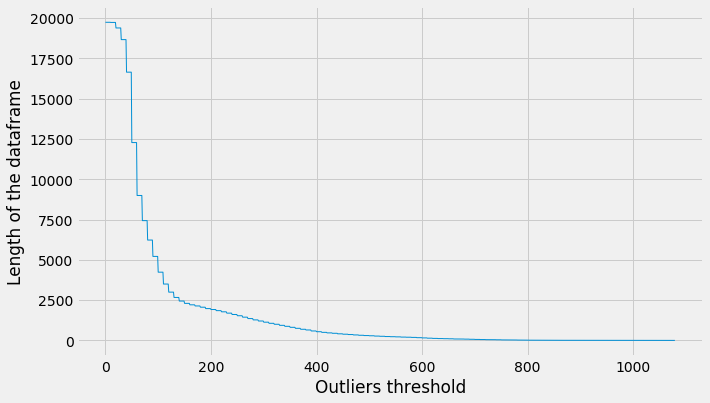

In [3]:
lengs = [ len(data) - len( data.drop(data[(data.appliance_wh > x)].index) )  for x in range(max(data.appliance_wh)) ]
plt.style.use('fivethirtyeight')
plt.figure(figsize = (10,6))
plt.plot(range(len(lengs)), lengs, linewidth = 1)
plt.xlabel('Outliers threshold'); plt.ylabel('Length of the dataframe')
print(lengs[399], lengs[599], lengs[699], lengs[789], sep = ", ")
#viz.plot_1(data)
data2 = data.copy()
data = data.drop(data[(data.appliance_wh > 600)|(data.appliance_wh < 0)].index)
data = data.reset_index()
data = data.drop(["index", "light_wh", "date"], axis = 1)
data.shape

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019D14EA6248>,
      dtype=object)

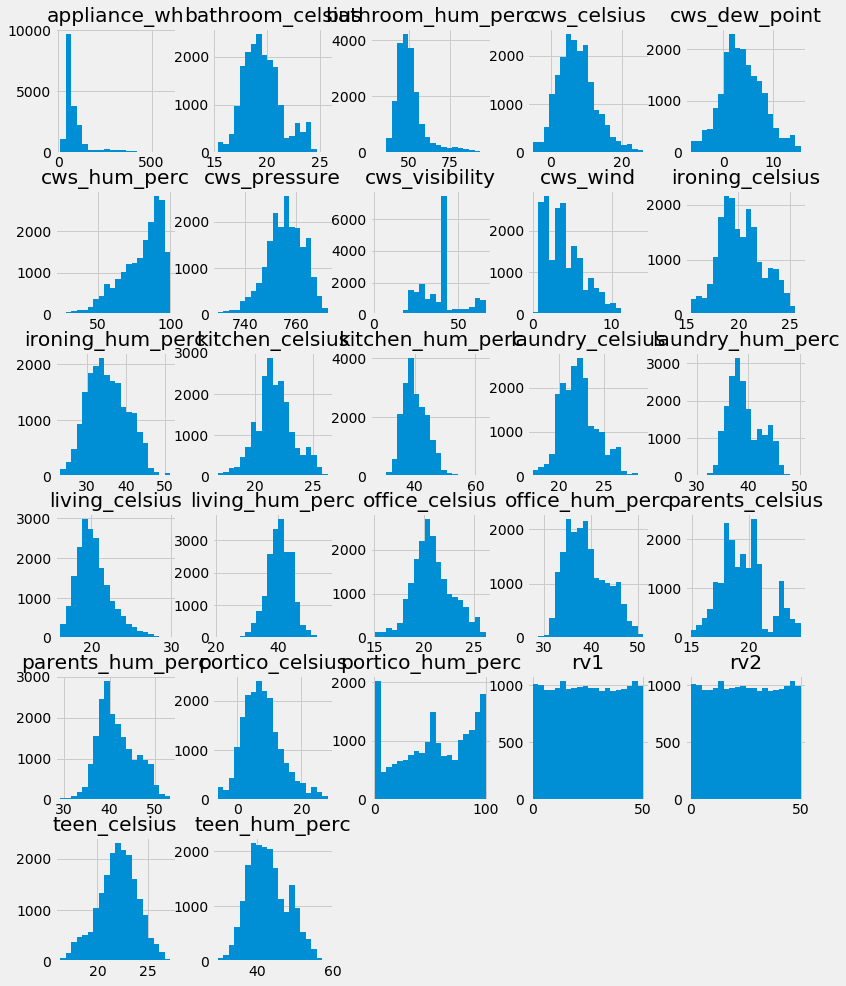

In [4]:
# Histogram of all the features to understand the distribution
plt.style.use('fivethirtyeight'); data.hist(bins = 20 , figsize = (12,16))

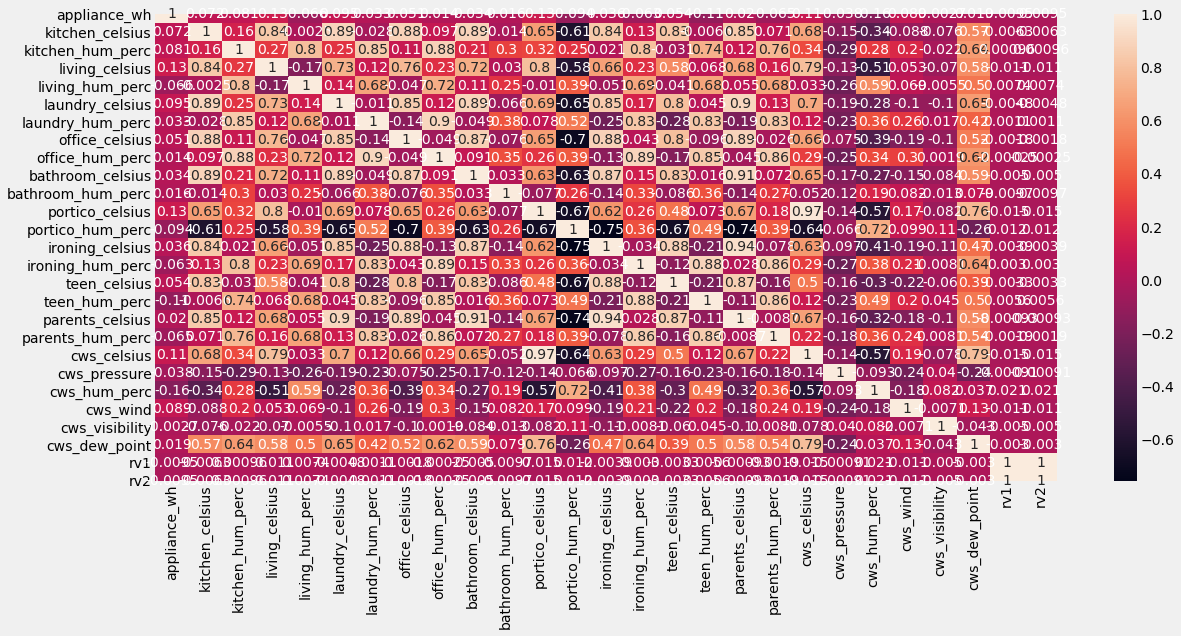

In [5]:
plt.figure(figsize = (18,8)); sns.heatmap(data.corr(), annot = True)

### Target, Features and Train Size
Set the target and the features matrices, with the train size equal to the $3/4$ of the sample size

In [6]:
X = data.drop("appliance_wh", axis = 1).values
y = np.log(data.appliance_wh)

X = X.reshape( (len(X), len(X[0])))
y = y.values.reshape( len(y), 1)
print(y.shape, X.shape)

train_size = int(len(X)*0.75)
X_train = X[:train_size]
X_test  = X[train_size:]
y_train = y[:train_size]
y_test  = y[train_size:]
print(train_size, len(X) - train_size)

(19580, 1) (19580, 26)
14685 4895


## LINEAR MODEL

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression(fit_intercept = True, n_jobs = -1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("R^2 = ", round(r2_score(y_test, y_pred), 5) )
lin_par = opt_tree.evaluate(y_test, y_pred)

lasso = lin_mod.lasso(data, X)
recursive = lin_mod.recurs_elimin(data, X, y)
#viz.plot_2(data, model, lasso, recursive)

R^2 =  0.15096
Model Performance
MAE: 0.36069
MSE: 0.24602
Variance: 0.08766
Accuracy: 91.81 %

Reducing features with LASSO 
	 ## Remaining features: 15 
	 ## R^2 after reduction: 0.1 
	 ## MSE after reduction: 0.27402 
	 ## Variance: 0.13243

Reducing features with Recursive Feature Elimination 
	 ## Remaining features: 18 
	 ## R^2 after reduction: 0.09841 
	 ## MSE after reduction: 0.2745 
	 ## Variance: 0.10624



In [8]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor(loss = "squared_loss", fit_intercept = True, random_state = 123, learning_rate = "optimal")
sgd.fit(X_train, y_train)

print("R^2 = ", round(r2_score(y_test, sgd.predict(X_test)), 5) )
print("MSE:", round(mean_squared_error(y_test, sgd.predict(X_test)), 5))

R^2 =  -1.6760096538196724e+31
MSE: 4.856505595344698e+30


## POLYNOMIAL MODEL

In [9]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
features_polynomial = poly.fit_transform(X_train)

model_2 = LinearRegression(fit_intercept = True)
model_2.fit(features_polynomial, y_train)

y_pred_2 = model_2.predict( poly.transform(X_test) )

print("R^2 = ", round(r2_score(y_test, y_pred_2), 5) )
pol_par = opt_tree.evaluate(y_test, y_pred_2)

R^2 =  -0.98545
Model Performance
MAE: 0.57755
MSE: 0.57532
Variance: 0.60886
Accuracy: 86.74 %



In [10]:
from sklearn.svm import SVR

supp = SVR(kernel = 'poly', degree = 2)
supp.fit(X_train, y_train)

print("R^2 = ", round(r2_score(y_test, supp.predict(X_test)), 5) )
supp_par = opt_tree.evaluate(y_test, supp.predict(X_test))

R^2 =  0.14184
Model Performance
MAE: 0.34628
MSE: 0.24867
Variance: 0.03949
Accuracy: 90.53 %



## DECISION TREE REGRESSOR

In [11]:
from sklearn.tree import DecisionTreeRegressor
decisiontree = DecisionTreeRegressor(random_state = 6)
model_tree = decisiontree.fit(X_train, y_train)
tree_pred = model_tree.predict(X_test)

tree_par = opt_tree.evaluate(y_test, tree_pred)
tree_imp = opt_tree.dtr_importance(data, model_tree)
print("Parameteres currently in use:")
pprint(decisiontree.get_params())

Model Performance
MAE: 0.69405
MSE: 0.82111
Variance: 0.43254
Accuracy: 82.75 %

                     values
living_celsius     0.097527
teen_hum_perc      0.073855
laundry_celsius    0.057955
bathroom_hum_perc  0.055666
kitchen_hum_perc   0.052026

Parameteres currently in use:
{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 6,
 'splitter': 'best'}


### Parameter tuning for Decision Tree

In [12]:
tree_tuned = DecisionTreeRegressor(ccp_alpha = 1, criterion = "mse", max_depth = 2,
                                   max_features = 13, max_leaf_nodes = 4, min_impurity_decrease = 0.009,
                                   min_impurity_split = 0.446, min_samples_leaf = 0.1, min_samples_split = 2,
                                   min_weight_fraction_leaf = 0.2, random_state = 529, splitter = "random")
model_tuned = tree_tuned.fit(X_train, y_train)
tuned_pred = model_tuned.predict(X_test)

tuned_par = opt_tree.evaluate(y_test, tuned_pred)

Model Performance
MAE: 0.38582
MSE: 0.29281
Variance: 0.0
Accuracy: 91.48 %



### AdaBoosting and Bagging of the Tree Regressor

In [13]:
from sklearn.ensemble import AdaBoostRegressor
adaboost = AdaBoostRegressor(base_estimator = tree_tuned, loss = "linear", random_state = 981, learning_rate = 0.001)
boost_model = adaboost.fit(X_train, y_train)
adaboost_pred = boost_model.predict(X_test)

tuned_par = opt_tree.evaluate(y_test, adaboost_pred)

Model Performance
MAE: 0.38636
MSE: 0.29255
Variance: 0.0
Accuracy: 91.46 %



In [14]:
from sklearn.ensemble import BaggingRegressor

bagged = BaggingRegressor(base_estimator = tree_tuned, random_state = 981)
bagg_model = bagged.fit(X_train, y_train)
bagg_pred = bagg_model.predict(X_test)

tuned_par = opt_tree.evaluate(y_test, bagg_pred)

Model Performance
MAE: 0.38619
MSE: 0.29263
Variance: 0.0
Accuracy: 91.46 %



## RANDOM FOREST REGRESSOR

In [15]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1000, random_state = 1234)
rf_model = rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_par = opt_tree.evaluate(y_test, rf_pred)
rf_imp = opt_tree.dtr_importance(data, rf_model)
print("Parameters currently in use:")
pprint(rf.get_params())

Model Performance
MAE: 0.58701
MSE: 0.48287
Variance: 0.12586
Accuracy: 84.6 %

                     values
living_celsius     0.099477
teen_hum_perc      0.069520
parents_hum_perc   0.063291
kitchen_hum_perc   0.057107
bathroom_hum_perc  0.052009

Parameters currently in use:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1234,
 'verbose': 0,
 'warm_start': False}


### Selection of the 8 most important features

In [16]:
imp_feats = ["living_celsius", "teen_hum_perc", "parents_hum_perc", "kitchen_hum_perc",
             "bathroom_hum_perc", "laundry_hum_perc", "teen_celsius", "portico_hum_perc"]
feat_drop = [x for x in data.columns if x not in imp_feats]

X_rf = data.drop(feat_drop, axis = 1).values
X_rf = X_rf.reshape( (len(X_rf), len(X_rf[0])))

X_train_rf =  X_rf[:train_size]
X_test_rf = X_rf[train_size:]

### Parameter tuning for Random Forest Regressor

Chunk 1: Parameters are chosen after RandomizedSearchCV

In [17]:
rf_tuned = RandomForestRegressor(n_estimators = 1000, min_samples_split = 5, min_samples_leaf = 1,
                                 max_features = 'sqrt', max_depth = None, bootstrap = False, random_state = 756)
model_rf_tuned = rf_tuned.fit(X_train_rf, y_train)
rf_tuned_pred = model_rf_tuned.predict(X_test_rf)

tuned_par_rf = opt_tree.evaluate(y_test, rf_tuned_pred)

Model Performance
MAE: 0.51947
MSE: 0.39272
Variance: 0.09173
Accuracy: 86.32 %



Chunk 2: Parameters are chosen after GridSearchCV

In [19]:
rf_tun_2 = RandomForestRegressor(n_estimators = 800, min_samples_split = 2, min_samples_leaf = 1,
                                 max_features = 'sqrt', max_depth = None, bootstrap = False, random_state = 234)
model_rf_tun_2 = rf_tun_2.fit(X_train_rf, y_train)
rf_tun_2_pred = model_rf_tun_2.predict(X_test_rf)

tuned_par_rf = opt_tree.evaluate(y_test, rf_tun_2_pred)

Model Performance
MAE: 0.51677
MSE: 0.38645
Variance: 0.08877
Accuracy: 86.34 %



## Forest with ```LightGBM```

In [10]:
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train_rf, y_train)
lgb_eval = lgb.Dataset(X_test_rf, y_test, reference = lgb_train)

forest = lgb.LGBMRegressor(boosting_type = 'rf', objective = "regression", metric = ["l1","l2"],
                           num_leaves = 300, max_depth = 500, learning_rate = 0.0001, num_iterations = 600,
                           feature_fraction = 0.9, bagging_fraction = 0.8, bagging_freq = 5, verbose = 0,
                           min_child_weight = 30, min_split_gain = 0.001, random_state = 1234)

forest.fit(X_train_rf, y_train)
for_pred = forest.predict(X_test_rf)

for_par = opt_tree.evaluate(y_test, for_pred)

Model Performance
MAE: 0.46236
MSE: 0.3391
Variance: 0.08278
Accuracy: 87.96 %



### Bayesian optimization

In [30]:
# fine tuning hyperparameters
def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight):
    # Default parameters
    params = {"application" : "regression", "num_iterations" : 5000,
              "learning_rate" : 0.05, "early_stopping_round" : 50, "metric" : 'l1'}
    
    # Add parameters 
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    
    # Cross Validation
    cv_result = lgb.cv(params, lgb_train, nfold = 5, seed = 7, stratified = False, verbose_eval = None, metrics = ["l1"])
    return -np.min(cv_result['l1-mean']) # negative of l1

In [31]:
from bayes_opt import BayesianOptimization
pds = { "num_leaves": (300, 500), "feature_fraction": (0.1, 0.9), "bagging_fraction": (0.8, 1),
        "max_depth": (500, 1000), "min_split_gain": (0.001, 0.1), "min_child_weight": (30, 50) }
# Surrogate model
optimizer = BayesianOptimization(hyp_lgbm, pds)

In [32]:
from bayes_opt import BayesianOptimization
pds = { "num_leaves": (300, 500), "feature_fraction": (0.1, 0.9), "bagging_fraction": (0.8, 1),
        "max_depth": (500, 1000), "min_split_gain": (0.001, 0.1), "min_child_weight": (30, 50) }
# Surrogate model
optimizer = BayesianOptimization(hyp_lgbm, pds)
                                  
# Optimize
optimizer.maximize(init_points = 5, n_iter = 15)
optimizer.max["params"]

|   iter    |  target   | baggin... | featur... | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------
|  1        | -0.0      |  0.8498   |  0.2355   |  892.0    |  38.79    |  0.03315  |  314.4    |
|  2        | -0.0      |  0.954    |  0.831    |  517.9    |  41.5     |  0.07099  |  358.1    |
|  3        | -0.0      |  0.9775   |  0.6173   |  917.7    |  45.21    |  0.0725   |  445.8    |
|  4        | -0.0      |  0.8503   |  0.7749   |  546.8    |  31.63    |  0.0307   |  371.7    |
|  5        | -0.0      |  0.8546   |  0.8093   |  780.2    |  48.47    |  0.06166  |  322.1    |
|  6        | -0.0      |  0.9683   |  0.4428   |  506.5    |  43.91    |  0.09569  |  499.5    |
|  7        | -0.0      |  0.9336   |  0.3237   |  994.2    |  31.56    |  0.002466 |  498.4    |
|  8        | -0.0      |  0.8196   |  0.7765   |  995.8    |  35.05    |  0.02179  |  301.3    |
|  9        | -0.0  

{'bagging_fraction': 0.8498280399094822,
 'feature_fraction': 0.2354537279321634,
 'max_depth': 892.0420811087158,
 'min_child_weight': 38.79205456785071,
 'min_split_gain': 0.03315328286109969,
 'num_leaves': 314.4476398465853}

In [9]:
forest_2 = lgb.LGBMRegressor(boosting_type = 'rf', objective = "regression", metric = ['l2', 'l1'],
                             num_leaves = 440, max_depth = 752, random_state = 1234,
                             learning_rate = 0.0001, num_iterations = 600, feature_fraction = 0.30908802314596395,
                             bagging_fraction = 0.8376848054627992, bagging_freq = 5, verbose = 0,
                             min_child_weight = 30.803558747467385, min_split_gain = 0.08407521026838967)

forest_2.fit(X_train_rf, y_train)
for_pred_2 = forest_2.predict(X_test_rf)

for_par_2 = opt_tree.evaluate(y_test, for_pred_2)

Model Performance
MAE: 0.39977
MSE: 0.27598
Variance: 0.02193
Accuracy: 89.94 %



-----------------------------------------
-----------------------------------------